In [94]:
from scipy.integrate import solve_ivp
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display, clear_output


from timeit import default_timer as tdt
import torch.nn.init as init

from softadapt import SoftAdapt, NormalizedSoftAdapt, LossWeightedSoftAdapt

if torch.cuda.is_available():
    my_device = 'cuda'
else:
    my_device = 'cpu'
    


In [95]:
# Time setup
n_days = 1000
t_num = torch.linspace(0, n_days, 1001)

## Disease setup
alpha_SIR = 0.005
beta_SIR = 0.025

# Initial conditions
N = 1.0    # Population size
I0_num = 0.1
R0_num = 0.0
S0_num = 1 - I0_num - R0_num    # Initial number of susceptible

In [96]:
# Solve numerically
def SIR_model_num(t, y, beta_SIR, alpha_SIR):
    S, I, R = y
    dSdt = -beta_SIR * S * I
    dIdt = beta_SIR * S * I - alpha_SIR * I
    dRdt = alpha_SIR * I
    return [dSdt, dIdt, dRdt]

# Setup initial conditions 
y0 = [S0_num, I0_num, R0_num]

# Solve using LSODA method from scipy
sol = solve_ivp(SIR_model_num, [t_num[0], t_num[-1]], y0, args=(beta_SIR, alpha_SIR), t_eval=t_num, method='LSODA')

S_data = torch.tensor(sol.y[0])
I_data = torch.tensor(sol.y[1])
R_data = torch.tensor(sol.y[2])
print(sol.message)

The solver successfully reached the end of the integration interval.


(<Figure size 800x400 with 1 Axes>,
 <Axes: title={'center': 'Ground Truth Solution'}, xlabel='Time [days]', ylabel='S(t), I(t), R(t) [fraction]'>)

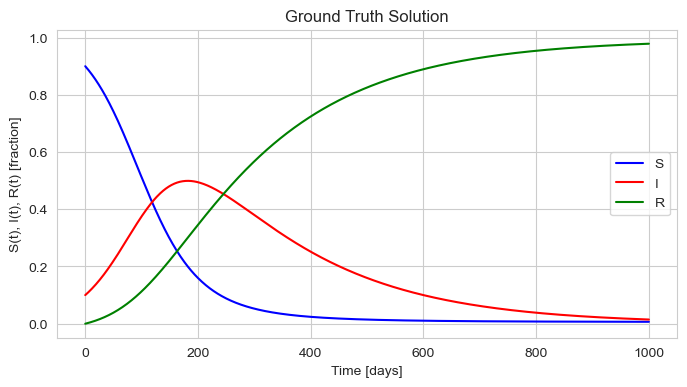

In [97]:
# Plot numerical solution
def plot_solution(t, S, I, R, title=''):
    t = t.clone().detach()
    S = S.clone().detach()
    I = I.clone().detach()
    R = R.clone().detach()
    fig, ax = plt.subplots(1, 1, figsize=(8,4))
    ax.plot(t, S, label='S', color='blue')
    ax.plot(t, I, label='I', color='red')
    ax.plot(t, R, label='R', color='green')

    ax.set_xlabel('Time [days]')
    ax.set_ylabel('S(t), I(t), R(t) [fraction]')
    ax.legend()
    ax.set_title(title)
    
    return fig, ax
    
plot_solution(t_num, S_data, I_data, R_data, 'Ground Truth Solution')

In [98]:
# Defining loss functions

torch_MSE_loss = torch.nn.MSELoss()

def get_loss_ode(t, net, beta_SIR, alpha_SIR):
    # Calculate net solution
    S, I, R = net(t)
    
    # Use autograd to get derivatives
    dSdt = torch.autograd.grad(S, t, grad_outputs=torch.ones_like(S), create_graph=True)[0]
    dIdt = torch.autograd.grad(I, t, grad_outputs=torch.ones_like(I), create_graph=True)[0]
    dRdt = torch.autograd.grad(R, t, grad_outputs=torch.ones_like(R), create_graph=True)[0]

    # Calculate MSE loss
    rhs = -beta_SIR * S * I
    loss_S = torch_MSE_loss(dSdt, rhs)
    
    rhs = beta_SIR * S * I - alpha_SIR * I
    loss_I = torch_MSE_loss(dIdt, rhs)
    
    rhs = alpha_SIR * I
    loss_R = torch_MSE_loss(dRdt, rhs)
    
    # Sum the errors
    loss = loss_S + loss_I + loss_R
    
    return loss, S, I, R

def get_loss_data(t, net, S_truth, I_truth, R_truth):
    
    # Reshaping
    t = t.view(-1,1) / 1000.0
    S_truth = S_truth.view(-1,1)
    I_truth = I_truth.view(-1,1)
    R_truth = R_truth.view(-1,1)
    
    # Calculate net solution
    S, I, R = net(t)
    
    # MSE loss between net result and truth
    loss_S = torch_MSE_loss(S, S_truth)
    loss_I = torch_MSE_loss(I, I_truth)
    loss_R = torch_MSE_loss(R, R_truth)
    
    # Sum loss
    loss = loss_S + loss_I + loss_R
    
    return loss

In [109]:
# ================== Defining the network(s) ==================
class FFN(nn.Module):
    def __init__(self, input_size, hidden_layers_size, output_size):
        super(FFN, self).__init__()
        
        n_layers = len(hidden_layers_size)
        HL = hidden_layers_size
        
        # Define layers
        self.L1 = nn.Linear(input_size, HL[0])
        self.L2 = nn.Linear(HL[0], HL[1])
        self.L3 = nn.Linear(HL[1], HL[2])
        #self.L3 = nn.Linear(HL[1], HL[2])
        #self.L3 = nn.Linear(HL[1], HL[2])

        
        self.output = nn.Linear(HL[-1], output_size)
        
        
        # Initialize weights and biases
        layers_list = [self.L1, self.L2, self.L3, self.output]
        for idx, layer in enumerate(layers_list):
            init.kaiming_normal_(layer.weight)
            init.zeros_(layer.bias)
            if idx == len(layers_list)-1:
                init.kaiming_normal_(layer.weight)
                init.zeros_(layer.bias)
                    
        # Define activation function
        self.act_fn = nn.Tanh()

    def forward(self, x):
        # Hidden layers
        x = self.act_fn(self.L1(x))
        x = self.act_fn(self.L2(x))
        x = self.act_fn(self.L3(x))

        # Output layer
        x = self.output(x)
    
        # Extract S, I, R from the network
        S = x[:,0].unsqueeze(1)
        I = x[:,1].unsqueeze(1)
        R = 1.0 - S - I
        
        S = torch.clamp(S, min=0.0, max=1.0)
        I = torch.clamp(I, min=0.0, max=1.0)
        R = torch.clamp(R, min=0.0, max=1.0)
        
        return S, I, R

net = FFN(1, [40, 40, 40], 3)
#for param in net.parameters():
#  print(param.data)

In [100]:
# Prepare t_num for network
t_num = t_num.view(-1,1)
#t_rescaled = t_num / 1000.0
print(t_num.squeeze())

tensor([   0.,    1.,    2.,  ...,  998.,  999., 1000.])


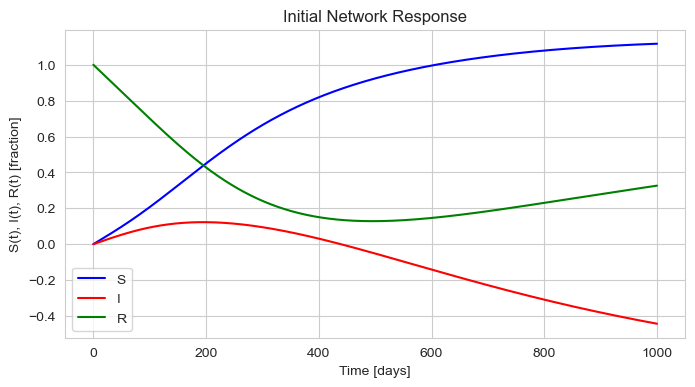

In [101]:
# Testing network
S, I, R = net(t_rescaled)
fig, ax = plot_solution(t_num, S, I, R, title='Initial Network Response')

In [102]:
# Testing ODE loss
t_num = t_num.clone().requires_grad_()
loss, _, _, _ = get_loss_ode(t_num, net, beta_SIR, alpha_SIR)
print(loss)

tensor(0.0146, grad_fn=<AddBackward0>)


In [103]:
# Testing IC loss
loss = get_loss_data(t_num[0], net, S_data[0], I_data[0], R_data[0])
print(loss)

tensor(1.8200, dtype=torch.float64, grad_fn=<AddBackward0>)


In [104]:
# Plots 
def monitor_plot():
    fig, ax = plt.subplots(1, 2, figsize=(12,5))
    line_loss_total, = ax[0].plot([0,1], [0,1], color='k', label='Total Loss')
    line_loss_ode, = ax[0].plot([0,1], [0,1], color='red', label='ODE Loss')
    line_loss_ic, = ax[0].plot([0,1], [0,1], color='blue', label='IC Loss')
    ax[0].legend()
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].set_yscale('log')
    
    ax[1].plot(t_num.detach(), S_data.detach(), color='blue', alpha=0.5)
    ax[1].plot(t_num.detach(), I_data.detach(), color='red', alpha=0.5)
    ax[1].plot(t_num.detach(), R_data.detach(), color='green', alpha=0.5)
    line_S, = ax[1].plot([0,1], [0,1], color='blue', linestyle='--', label='S')
    line_I, = ax[1].plot([0,1], [0,1], color='red', linestyle='--', label='I')
    line_R, = ax[1].plot([0,1], [0,1], color='green', linestyle='--', label='R')
    ax[1].legend()
    ax[1].set_xlabel('Time [days]')
    ax[1].set_ylabel('S, I, R - (t)')
    
    return fig, ax, line_loss_total, line_loss_ode, line_loss_ic, line_S, line_I, line_R

In [110]:
# SoftAdapt setup
softadapt_obj  = LossWeightedSoftAdapt(beta=0.1)
epochs_to_make_change = 5
adapt_weights = torch.tensor([0.5, 0.5])    # Initial weighting of objects.

# Setup optimizer
learning_rate = 3e-4
optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-5)
#optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-5)

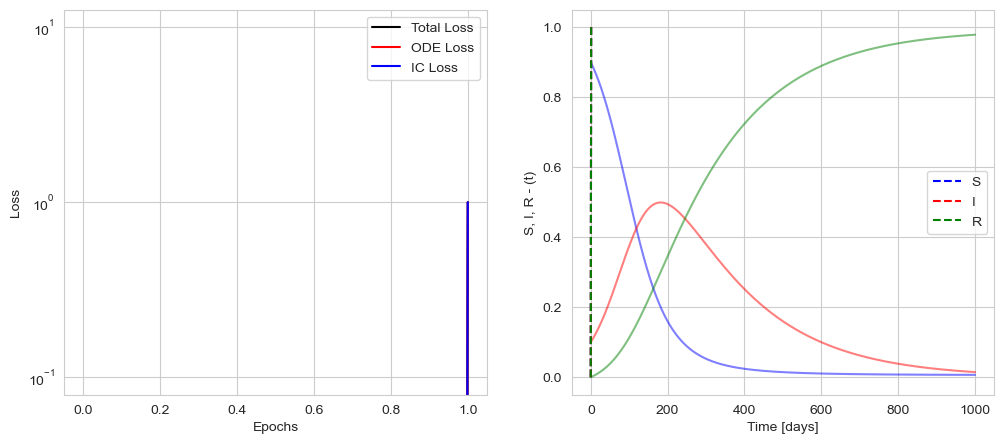

Epoch     1, Loss: 0.00327987, ode_loss: 0.00440005, ic_loss: 0.00000001, data_loss 1.3988669,
             aw[0]: 0.745417, aw[1]: 0.151639,
Epoch   100, Loss: 0.00066018, ode_loss: 0.00072617, ic_loss: 0.00002900, data_loss 1.1445062,
             aw[0]: 0.905358, aw[1]: 0.094619,
Epoch   200, Loss: 0.00028873, ode_loss: 0.00034996, ic_loss: 0.00000776, data_loss 1.2323452,
             aw[0]: 0.821050, aw[1]: 0.178928,
Epoch   300, Loss: 0.00018655, ode_loss: 0.00021775, ic_loss: 0.00000286, data_loss 1.2306030,
             aw[0]: 0.854830, aw[1]: 0.145132,
Epoch   400, Loss: 0.00013218, ode_loss: 0.00015148, ic_loss: 0.00000951, data_loss 1.2417955,
             aw[0]: 0.864033, aw[1]: 0.135911,
Epoch   500, Loss: 0.00010258, ode_loss: 0.00011012, ic_loss: 0.00001738, data_loss 1.2128588,
             aw[0]: 0.918747, aw[1]: 0.081171,
Epoch   600, Loss: 0.00008473, ode_loss: 0.00008755, ic_loss: 0.00001148, data_loss 1.2530148,
             aw[0]: 0.962992, aw[1]: 0.036897,
Epoch 

In [114]:
num_epochs = 1000
save_every = 100
loss1, loss2 = [], []

epochs_saved = []
loss_saved = []
loss_ode_saved = []
loss_ic_saved = []

# Create plot
fig, ax, line_loss_total, line_loss_ode, line_loss_ic, line_S, line_I, line_R = monitor_plot()
plt.show()

net = net.to(my_device)
t_num_cuda = t_num.clone().to(my_device)
S_data_cuda = S_data.to(my_device).type(torch.float32)
S0 = torch.tensor(S0_num, device=my_device)
I_data_cuda = I_data.to(my_device).type(torch.float32)
I0 = torch.tensor(I0_num, device=my_device)
R_data_cuda = R_data.to(my_device).type(torch.float32)
R0 = torch.tensor(R0_num, device=my_device)


for epoch in range(num_epochs):
    net.train()
    optimizer.zero_grad()

    # Get network response
    t_train = torch.linspace(0, 50, 1001, device=my_device, requires_grad=True).unsqueeze(1)
    #t_train = t_train / 1000.0
    
    # Loss
    loss_ode, S, I, R = get_loss_ode(t_train, net, beta_SIR, alpha_SIR)
    loss_ic = get_loss_data(t_train[0], net, S0, I0, R0)
    loss_data = get_loss_data(t_num_cuda, net, S_data_cuda, I_data_cuda, R_data_cuda)
    # Unsqueeze time
    #t_train = t_train * 1000.0
    
    loss1.append( loss_ode )
    loss2.append( loss_ic )
    
    # SoftAdapt using their package since lazy
    if epoch % epochs_to_make_change == 0 and epoch != 0:
        adapt_weights = softadapt_obj.get_component_weights(torch.tensor(loss1),
                                                            torch.tensor(loss2),
                                                            verbose=False)
        loss1, loss2 = [], []
    
    loss = adapt_weights[0] * loss_ode + adapt_weights[1] * loss_ic
    
    loss.backward()
    optimizer.step()
    
    if False:
        if (epoch+1) % save_every == 0 or epoch == 0:
            epochs_saved.append( epoch )
            loss_saved.append( loss.to('cpu').detach() )
            loss_ode_saved.append( loss_ode.to('cpu').detach() )
            loss_ic_saved.append( loss_ic.to('cpu').detach() )

            # Change plot [0]
            line_loss_total.set_data(epochs_saved, loss_saved)
            line_loss_ode.set_data(epochs_saved, loss_ode_saved)
            line_loss_ic.set_data(epochs_saved, loss_ic_saved)
            ax[0].set_xlim(0, max(epochs_saved) + 100)
            max_val = max([max(loss_saved), max(loss_ode_saved), max(loss_ic_saved)])
            ax[0].set_ylim(1e-12, max_val*2)

            line_S.set_data(t_train.to('cpu').detach(), S.to('cpu').detach())
            line_I.set_data(t_train.to('cpu').detach(), I.to('cpu').detach())
            line_R.set_data(t_train.to('cpu').detach(), R.to('cpu').detach())

            display(fig)
            clear_output(wait = True)
    else:
        if (epoch+1) % save_every == 0 or epoch == 0:
            print(f"Epoch {epoch+1:5}, Loss: {loss.item():8.8f}, ode_loss: {loss_ode:8.8f}, ic_loss: {loss_ic:8.8f}"
                  f", data_loss {loss_data:7.7f},"
                  f"\n             aw[0]: {adapt_weights[0]:3.6f}, aw[1]: {adapt_weights[1]:3.6f},")
    
    
    

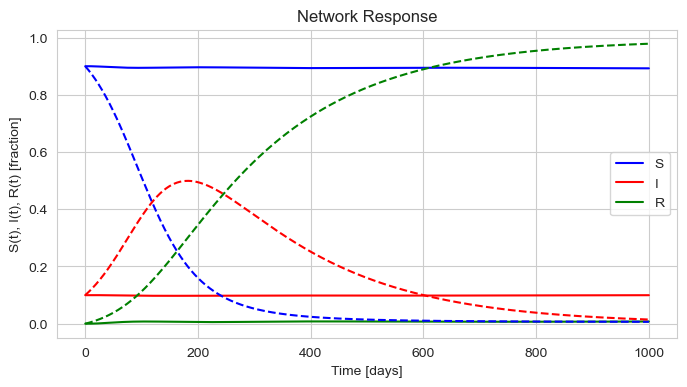

In [115]:
# Prepare t_num for network
net_cpu = net.to('cpu').eval()
t_num = t_num.view(-1,1)
t_rescaled = t_num / 1000.0
# Testing network
S, I, R = net(t_rescaled)
fig, ax = plot_solution(t_num, S, I, R, title='Network Response')
ax.plot(t_num.to('cpu').detach(), S_data.to('cpu').detach(), color='blue', linestyle='--')
ax.plot(t_num.to('cpu').detach(), I_data.to('cpu').detach(), color='red', linestyle='--')
ax.plot(t_num.to('cpu').detach(), R_data.to('cpu').detach(), color='green', linestyle='--')